Current Notebook:
1. Copy V2
2. Hypothesis Test -- Scaling only X 
3. Hypothesis Test -- Removing Initial Zero Demand values per series 

Next Notebook:
1. Decision -- Removing Initial Zero Demand values per series 
2. Decision -- Scaling only X 
3. Hypothesis Test -- Sample Weights
4. Hypothesis Test -- More Features 

In [1]:
MODEL_VERSION = "04"
NUM_TIMESTEPS = 28
RUN_ON_SAMPLE = False
SAMPLE_SIZE = 500
SCALING = False

DROPOUT = 0.3
MIN_LR = 1e-4
MAX_LR = 1e-2
STEP_SIZE = 2
BATCH_SIZE = 10*1024
PREDICT_BATCH_SIZE = 20*1024
NUM_EPOCHS = [4, 28, 4]

MC_DROPOUT = False
MC_SAMPLES = 10 if MC_DROPOUT else 1

In [2]:
import os, sys, datetime, pickle, gc
from time import time, ctime
from pprint import pprint
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, TimeDistributed
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RepeatVector, Lambda
from tensorflow.keras.backend import repeat_elements
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import TriangularCyclicalLearningRate
from tensorflow_addons.losses import PinballLoss

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [4]:
seeded_value = 88888
pd.set_option('display.max_colwidth', 50)
np.random.seed(seeded_value)
tf.random.set_seed(seeded_value)

In [5]:
# suppress scientific notation
pd.options.display.precision = 2
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [6]:
print([
    tf.__version__
])

['2.2.0']


In [7]:
start_time = time()
start = datetime.now()
print(ctime(start_time))

Fri Jun 26 06:27:23 2020


### Files
1. calendar.csv - Contains information about the dates on which the products are sold.
2. sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
3. sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
4. sell_prices.csv - Contains information about the price of the products sold per store and date.
5. sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

In [8]:
DATA_DIR = "../data/"
RESULTS_DIR = "../results/"
PICKLE_DIR = "../data/preprocessed/"

In [9]:
CARDINAL_VARS = ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id', 'id']

In [10]:
TRAIN_INDICES = np.arange(1, 1885 + 1) # Could use 1156 i.e. only 2 years of data
VALID_INDICES = np.arange(1886, 1913 + 1)
PUBLIC_INDICES = np.arange(1914, 1941 + 1)
PRIVATE_INDICES = np.arange(1942, 1969 + 1)

In [11]:
print(min(TRAIN_INDICES), max(TRAIN_INDICES), len(TRAIN_INDICES))
print(min(VALID_INDICES), max(VALID_INDICES), len(VALID_INDICES))
print(min(PUBLIC_INDICES), max(PUBLIC_INDICES), len(PUBLIC_INDICES))
print(min(PRIVATE_INDICES), max(PRIVATE_INDICES), len(PRIVATE_INDICES))

1 1885 1885
1886 1913 28
1914 1941 28
1942 1969 28


Read about memory management in pandas [here](https://pythonspeed.com/articles/pandas-load-less-data/)

In [12]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [13]:
def read_data(infer_mode:bool=False):
    print('Reading files...')
    
    calendar = pd.read_csv('../data/calendar.csv').fillna("None")
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    
    sell_prices = pd.read_csv('../data/sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    
    sales = pd.read_csv('../data/sales_train_evaluation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales.shape[0], sales.shape[1]))
    sales[['d_'+str(i) for i in PRIVATE_INDICES]] = pd.DataFrame(np.zeros(shape=(sales.shape[0], len(PRIVATE_INDICES))))
    print('Sales train validation has {} rows and {} columns'.format(sales.shape[0], sales.shape[1]))
    
    submission = pd.read_csv('../data/sample_submission.csv')
    
    pprint({
        "calendar.shape" : calendar.shape,
        "sell_prices.shape" : sell_prices.shape,
        "sales.shape" : sales.shape,
        "submission.shape" : submission.shape
    })
    
    return calendar, sell_prices, sales, submission

In [14]:
def add_dateparts(calendar, datecolname):
    calendar["Date"] = pd.to_datetime(calendar[datecolname], format = ("%Y-%m-%d"))
    calendar["Year"] = calendar["Date"].dt.year.astype('int16')
    calendar["Quarter"] = calendar["Date"].dt.quarter
    calendar["Month"] = calendar["Date"].dt.month
    calendar["Week"] = calendar["Date"].dt.week
    calendar["Day"] = calendar["Date"].dt.day
    calendar["DOW"] = calendar["Date"].dt.dayofweek
    calendar = reduce_mem_usage(calendar)
    return calendar

In [15]:
def melt_join_fill(sales, calendar, sell_prices):
    print("[INFO] ", "Starting  -- COMPLETE", ctime(time()))
    if RUN_ON_SAMPLE:
        sales = pd.melt(sales.sample(SAMPLE_SIZE),
                        id_vars=CARDINAL_VARS,
                        value_vars=Y_VARS,
                        var_name="day_id",
                        value_name='demand')
    else:
        sales = pd.melt(sales,
                        id_vars=CARDINAL_VARS,
                        value_vars=Y_VARS,
                        var_name="day_id",
                        value_name='demand')
    print("[INFO] ", "Melting  -- COMPLETE", ctime(time()))

    gc.collect()
    
    sales = pd.merge(sales, calendar, how="left", left_on="day_id", right_on="d")
    print("[INFO] ", "Merging1 -- COMPLETE", ctime(time()))
    
    gc.collect()
    
    sales = pd.merge(sales, sell_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
    print("[INFO] ", "Merging2 -- COMPLETE", ctime(time()))
    
    gc.collect()
    
    # if sell_price is NA
    sales = sales.sort_values(by=CARDINAL_VARS+["date"])
    print("[INFO] ", "Sorting -- COMPLETE", ctime(time()))
    
    # remove till first non-zero demand per series
    before = sales.shape
    sales['cumul_demand'] = sales.groupby(['id'])['demand'].cumsum()
    sales = sales.loc[sales['cumul_demand']>0].copy().reset_index(drop=True)
    after = sales.shape
    print("[INFO] ", "Removal -- COMPLETE", ctime(time()))
    print("[INFO] ", "Removal", before, "--->", after)
    
    gc.collect()
    
    sales["sell_price_available"] = np.where(sales.sell_price.isna(), "N", "Y")
    sales[["sell_price"]] = sales.groupby(["item_id"])[["sell_price"]].ffill()
    sales[["sell_price"]] = sales.groupby(["item_id"])[["sell_price"]].bfill()
    sales = sales.drop(["d", "wday", 'date', 'wm_yr_wk', 'weekday', 'month', 'year'], axis=1)
    
    sales['day_id'] = sales['day_id'].astype(str).apply(lambda x: x[2:]).astype(np.int16)
    
    print("[INFO] ", "Imputing -- COMPLETE", ctime(time()))    
    
    gc.collect()
    
    sales['weights'] = sales["sell_price"] * sales["demand"]
    sales['rolling_weights'] = sales.groupby(CARDINAL_VARS)['weights'].rolling(window=NUM_TIMESTEPS, min_periods=1).sum().reset_index(drop=True)
    
    sales['weights'] = sales['weights'].apply(lambda x: np.max((1.0, x)))
    sales['rolling_weights'] = sales['rolling_weights'].apply(lambda x: np.max((1.0, x)))
    
    print("[INFO] ", "Weighting -- COMPLETE", ctime(time()))    
    
    gc.collect()
    
    print("[INFO] ", "Final dataset contains", sales.shape)
    
    return sales.reset_index(drop=True)

In [16]:
if not os.path.exists(PICKLE_DIR+"merged_df_"+MODEL_VERSION+".pickle"):
    
    calendar, sell_prices, sales, submission = read_data()
    
    calendar = add_dateparts(calendar, "date")
    
    Y_VARS = sales.columns[sales.columns.str.startswith("d_")]

    data = melt_join_fill(sales, calendar, sell_prices)
    
    del sales, calendar, sell_prices
    gc.collect()

    print("Saving all data to ---> ", PICKLE_DIR)
    with open(os.path.join(PICKLE_DIR, "merged_df_"+MODEL_VERSION+".pickle"),"wb") as f:
        pickle.dump((data), f)
else:
    print("Pickle exists hence loading from pickle file ---> ", PICKLE_DIR)
    with open(os.path.join(PICKLE_DIR+"merged_df_"+MODEL_VERSION+".pickle"), "rb") as f:
        data = pickle.load(f)

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1947 columns
Sales train validation has 30490 rows and 1975 columns
{'calendar.shape': (1969, 14),
 'sales.shape': (30490, 1975),
 'sell_prices.shape': (6841121, 4),
 'submission.shape': (60980, 29)}
Mem. usage decreased to  0.15 Mb (30.4% reduction)
[INFO]  Starting  -- COMPLETE Fri Jun 26 06:27:30 2020
[INFO]  Melting  -- COMPLETE Fri Jun 26 06:27:43 2020
[INFO]  Merging1 -- COMPLETE Fri Jun 26 06:28:05 2020
[INFO]  Merging2 -- COMPLETE Fri Jun 26 06:28:42 2020
[INFO]  Sorting -- COMPLETE Fri Jun 26 06:30:14 2020
[INFO]  Removal -- COMPLETE Fri Jun 26 06:30:38 2020
[INFO]  Removal (60034810, 30) ---> (47649940, 31)
[INFO]  Imputing -- COMPLETE Fri Jun 26 06:31:24 2020
[INFO]  Weighting -- COMPLETE Fri Jun 26 06:44:04 2020
[INFO]  Final dataset c

In [17]:
1913-28, 1913, 1913 + 28, 1913 + 28 + 28

(1885, 1913, 1941, 1969)

In [18]:
data.Date.min(), data.Date.max()#, data.Date.max() + 28, data.Date.max() + 28 + 28

(Timestamp('2011-01-29 00:00:00'), Timestamp('2016-06-19 00:00:00'))

In [19]:
print(data.shape); data.head()

(47649940, 27)


,state_id,store_id,cat_id,dept_id,item_id,id,day_id,demand,event_name_1,event_type_1,...,Quarter,Month,Week,Day,DOW,sell_price,cumul_demand,sell_price_available,weights,rolling_weights
0,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,1,3.00,None,None,...,1,1,4,29,5,2.00,3.00,Y,6.00,6.00
1,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,2,0.00,None,None,...,1,1,4,30,6,2.00,3.00,Y,1.00,6.00
2,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,3,0.00,None,None,...,1,1,5,31,0,2.00,3.00,Y,1.00,6.00
3,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,4,1.00,None,None,...,1,2,5,1,1,2.00,4.00,Y,2.00,8.00
4,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,5,4.00,None,None,...,1,2,5,2,2,2.00,8.00,Y,8.00,16.00


# Preprocessing

In [20]:
CONT_VARS = ['snap_CA', 'snap_TX', 'snap_WI', 'sell_price']
CAT_VARS = ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id', 'event_name_1',
            'event_type_1', 'event_name_2', 'event_type_2', 'Year', 'Quarter',
            'Month', 'Week', 'Day', 'DOW', 'sell_price_available']
DEP_VAR = ['demand']
WEIGHT_VAR = ['weights', 'rolling_weights']

### Categorical Data

In [21]:
Category_Mapping = {}
for c in CAT_VARS:
    # convert columns to categories
    data[c+"_cat"] = data[c].astype("category")
    
    # save the mapping for later use
    Category_Mapping.update({c+"_cat" : dict(enumerate(data[c+"_cat"].cat.categories))})
    
    # Copy categories as integer codes
    data[c+"_cat"] = data[c+"_cat"].cat.codes

In [22]:
Unique_Dict ={}
for c in CAT_VARS:
    col = c+"_cat"
    Unique_Dict.update({col:{'min':data[col].min(), 
                             'max':data[col].max(), 
                             'nuniq':data[col].nunique(), 
                             'emb_sz':max(min(int(data[col].nunique() / 2), 10), 2)}})
pprint(Unique_Dict)

{'DOW_cat': {'emb_sz': 3, 'max': 6, 'min': 0, 'nuniq': 7},
 'Day_cat': {'emb_sz': 10, 'max': 30, 'min': 0, 'nuniq': 31},
 'Month_cat': {'emb_sz': 6, 'max': 11, 'min': 0, 'nuniq': 12},
 'Quarter_cat': {'emb_sz': 2, 'max': 3, 'min': 0, 'nuniq': 4},
 'Week_cat': {'emb_sz': 10, 'max': 52, 'min': 0, 'nuniq': 53},
 'Year_cat': {'emb_sz': 3, 'max': 5, 'min': 0, 'nuniq': 6},
 'cat_id_cat': {'emb_sz': 2, 'max': 2, 'min': 0, 'nuniq': 3},
 'dept_id_cat': {'emb_sz': 3, 'max': 6, 'min': 0, 'nuniq': 7},
 'event_name_1_cat': {'emb_sz': 10, 'max': 30, 'min': 0, 'nuniq': 31},
 'event_name_2_cat': {'emb_sz': 2, 'max': 4, 'min': 0, 'nuniq': 5},
 'event_type_1_cat': {'emb_sz': 2, 'max': 4, 'min': 0, 'nuniq': 5},
 'event_type_2_cat': {'emb_sz': 2, 'max': 2, 'min': 0, 'nuniq': 3},
 'item_id_cat': {'emb_sz': 10, 'max': 3048, 'min': 0, 'nuniq': 3049},
 'sell_price_available_cat': {'emb_sz': 2, 'max': 0, 'min': 0, 'nuniq': 1},
 'state_id_cat': {'emb_sz': 2, 'max': 2, 'min': 0, 'nuniq': 3},
 'store_id_cat': {'e

In [23]:
NEW_CAT_VARS = [col+"_cat" for col in CAT_VARS]

### Numerical Data

In [24]:
MMS = MinMaxScaler()
data[CONT_VARS] = MMS.fit_transform(data[CONT_VARS])

if SCALING:

    MMS_Y = MinMaxScaler(feature_range=(0, 0.8))
    data[DEP_VAR] = MMS_Y.fit_transform(data[DEP_VAR])

# Cross Validation

In [25]:
data['set'] = np.where(data.day_id.isin(TRAIN_INDICES), "Train",
                       np.where(data.day_id.isin(VALID_INDICES), "Valid",
                                np.where(data.day_id.isin(PUBLIC_INDICES), "Public", "Private")))

In [26]:
data.groupby('set').agg({
    'id':'count',
    'day_id':[np.min, np.max]
})

id day_id      
            count   amin  amax
set                           
Private    853720   1942  1969
Public     853720   1914  1941
Train    45088780      1  1885
Valid      853720   1886  1913

In [27]:
train_data = data.loc[data.day_id.isin(TRAIN_INDICES)]
valid_data = data.loc[data.day_id.isin(VALID_INDICES)]
public_data = data.loc[data.day_id.isin(PUBLIC_INDICES)]
private_data = data.loc[data.day_id.isin(PRIVATE_INDICES)]
train_data.shape, valid_data.shape, public_data.shape, private_data.shape

((45088780, 44), (853720, 44), (853720, 44), (853720, 44))

In [28]:
data.shape[0] == train_data.shape[0] + valid_data.shape[0] + private_data.shape[0] + private_data.shape[0]

True

In [29]:
model_time = time()
model_t = datetime.now()
print(ctime(model_time))

Fri Jun 26 06:46:54 2020


# Model Specification

In [30]:
def build_model():
    layers = []
    inputs = []
    for i,col in enumerate(CAT_VARS):
        input_ = Input(shape=1, name=col+"_cat")
        embedding =  Embedding(Unique_Dict[col+"_cat"]['nuniq'],
                               Unique_Dict[col+"_cat"]['emb_sz'],
                               name='emb_'+col)(input_)
        vec = Flatten()(embedding)
        layers.append(vec)
        inputs.append(input_)
    
    for i, col in enumerate(CONT_VARS):
        input_ = Input(shape=1, name=col)
        layers.append(input_)
        inputs.append(input_)
    
    concat_layer = concatenate(layers)
    x = Dense(2048)(concat_layer)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)

    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)
    
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)
    
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)
    
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)
    
    x = Dense(32)(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)
    
    if SCALING:
        demand = Dense(1, activation='sigmoid', name='demand')(x)
    else:
        demand = Dense(1, activation='relu', name='demand')(x)
    
    model = Model(inputs, demand)
    
    return model

In [31]:
model = build_model()

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state_id_cat (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
store_id_cat (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_id_cat (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
dept_id_cat (InputLayer)        [(None, 1)]          0                                            
______________________________________________________________________________________________

In [33]:
if os.path.exists(RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5"):
    model.load_weights(RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5")

In [34]:
tclr = TriangularCyclicalLearningRate(
    initial_learning_rate=MIN_LR,
    maximal_learning_rate=MAX_LR,
    step_size=STEP_SIZE * len(train_data)
)

In [35]:
mcp = ModelCheckpoint(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5", monitor='val_loss',
                      verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch')
csvl = CSVLogger(filename=RESULTS_DIR+"LossLogs_"+MODEL_VERSION+".csv",
                 separator=",", append=True)

In [ ]:
PBL = PinballLoss(tau=[0.005,0.025,0.165,0.25,0.5,0.75,0.835,0.975,0.995])

In [36]:
adam = Adam(learning_rate=MAX_LR)
model.compile(loss= PBL if MC_DROPOUT else 'mse', optimizer=adam)

In [37]:
history = model.fit(x=train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                    y=train_data[DEP_VAR].to_dict(orient='series'),
                    validation_data=(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     valid_data[DEP_VAR].to_dict(orient='series'),
                                     valid_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights']
                                    ),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[0],
                    shuffle=True,
                    verbose=1,
                    sample_weight=train_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights'],
                    callbacks=[mcp, csvl])

Epoch 1/4
4404/4404 [==============================] - 639s 145ms/step - loss: 10273.9004 - val_loss: 3692.9207
Epoch 2/4
4404/4404 [==============================] - 637s 145ms/step - loss: 8024.4727 - val_loss: 3435.6060
Epoch 3/4
4404/4404 [==============================] - 634s 144ms/step - loss: 7149.9399 - val_loss: 4310.1562
Epoch 4/4
4404/4404 [==============================] - 632s 144ms/step - loss: 6404.4751 - val_loss: 3664.9060


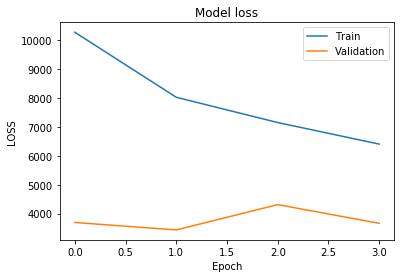

In [38]:
metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [39]:
model = tf.keras.models.load_model(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5", compile=False)

In [40]:
adam = Adam(learning_rate=tclr)
model.compile(loss=PBL if MC_DROPOUT else 'mse', optimizer=adam)

In [41]:
history = model.fit(x=train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                    y=train_data[DEP_VAR].to_dict(orient='series'),
                    validation_data=(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     valid_data[DEP_VAR].to_dict(orient='series'),
                                     valid_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights']
                                    ),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[1],
                    shuffle=True,
                    verbose=1, 
                    sample_weight=train_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights'],
                    callbacks=[mcp, csvl])

Epoch 1/28
4404/4404 [==============================] - 636s 144ms/step - loss: 6687.3687 - val_loss: 3193.7146
Epoch 2/28
4404/4404 [==============================] - 635s 144ms/step - loss: 6412.1240 - val_loss: 3194.8804
Epoch 3/28
4404/4404 [==============================] - 635s 144ms/step - loss: 6363.0112 - val_loss: 3194.1772
Epoch 4/28
4404/4404 [==============================] - 636s 144ms/step - loss: 6296.9614 - val_loss: 3169.6328
Epoch 5/28
4404/4404 [==============================] - 636s 144ms/step - loss: 6217.9438 - val_loss: 3141.3147
Epoch 6/28
4404/4404 [==============================] - 635s 144ms/step - loss: 6173.5000 - val_loss: 3147.7666
Epoch 7/28
4404/4404 [==============================] - 625s 142ms/step - loss: 6130.7207 - val_loss: 3150.9692
Epoch 8/28
4404/4404 [==============================] - 625s 142ms/step - loss: 6066.8564 - val_loss: 3131.0142
Epoch 9/28
4404/4404 [==============================] - 629s 143ms/step - loss: 6027.3169 - val_loss: 31

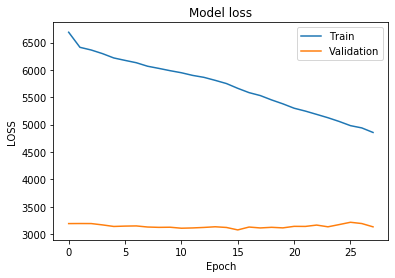

In [42]:
metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model ' + i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [43]:
model = tf.keras.models.load_model(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5", compile=False)

In [44]:
adam = Adam(learning_rate=MIN_LR*0.1)
model.compile(loss=PBL if MC_DROPOUT else 'mse', optimizer=adam)

In [45]:
history = model.fit(x=train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                    y=train_data[DEP_VAR].to_dict(orient='series'),
                    validation_data=(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     valid_data[DEP_VAR].to_dict(orient='series'),
                                     valid_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights']
                                    ),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[2],
                    shuffle=True,
                    verbose=1, 
                    sample_weight=train_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights'],
                    callbacks=[mcp, csvl])

Epoch 1/4
4404/4404 [==============================] - 635s 144ms/step - loss: 5604.0669 - val_loss: 3099.5007
Epoch 2/4
4404/4404 [==============================] - 636s 144ms/step - loss: 5542.2935 - val_loss: 3108.0337
Epoch 3/4
4404/4404 [==============================] - 636s 144ms/step - loss: 5574.7534 - val_loss: 3103.3340
Epoch 4/4
4404/4404 [==============================] - 635s 144ms/step - loss: 5577.5635 - val_loss: 3107.4734


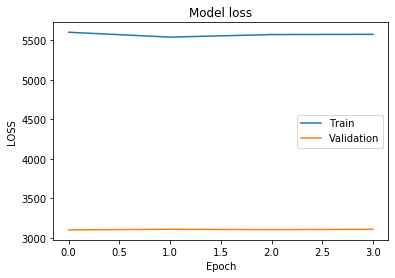

In [46]:
metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [47]:
model.save(filepath=RESULTS_DIR+"FinalCheckpoint_"+MODEL_VERSION+".h5", overwrite=True)

# Validation

In [48]:
if os.path.exists(RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5"):
    model = tf.keras.models.load_model(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5", compile=False)

In [49]:
for i in range(MC_SAMPLES):
    if i == 0:
        train_preds = model.predict(train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                    batch_size=PREDICT_BATCH_SIZE, verbose=0)

        valid_preds = model.predict(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                    batch_size=PREDICT_BATCH_SIZE, verbose=0)

        public_preds = model.predict(public_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     batch_size=PREDICT_BATCH_SIZE, verbose=0)

        private_preds = model.predict(private_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                      batch_size=PREDICT_BATCH_SIZE, verbose=0)
        
    else:
        train_preds = np.concatenate((train_preds, 
                                      model.predict(train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                                    batch_size=PREDICT_BATCH_SIZE, verbose=0)), axis=1)

        valid_preds = np.concatenate((valid_preds, 
                                      model.predict(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                                    batch_size=PREDICT_BATCH_SIZE, verbose=0)), axis=1)

        public_preds = np.concatenate((public_preds, 
                                       model.predict(public_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                                     batch_size=PREDICT_BATCH_SIZE, verbose=0)), axis=1)

        private_preds = np.concatenate((private_preds, 
                                        model.predict(private_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                                      batch_size=PREDICT_BATCH_SIZE, verbose=0)), axis=1)

print(train_preds.shape, valid_preds.shape, public_preds.shape, private_preds.shape)

(45088780, 1) (853720, 1) (853720, 1) (853720, 1)


In [50]:
if SCALING:
    train_demand = MMS_Y.inverse_transform(train_preds)
    valid_demand = MMS_Y.inverse_transform(valid_preds)
    public_demand = MMS_Y.inverse_transform(public_preds)
    private_demand = MMS_Y.inverse_transform(private_preds)
    
    data['prediction'] = 0
    data[['prediction']].loc[data.day_id.isin(TRAIN_INDICES)] = train_preds
    data[['prediction']].loc[data.day_id.isin(VALID_INDICES)] = valid_preds
    data[['prediction']].loc[data.day_id.isin(PUBLIC_INDICES)] = public_preds
    data[['prediction']].loc[data.day_id.isin(PRIVATE_INDICES)] = private_preds

    data['demand_Unscaled'] = MMS_Y.inverse_transform(data[['demand']])
    data[[col+'_Unscaled' for col in CONT_VARS]] = pd.DataFrame(MMS.inverse_transform(data[CONT_VARS]))

In [51]:
data['pred_demand'] = 0

if SCALING:
    data['pred_demand'].loc[data.day_id.isin(TRAIN_INDICES)] = train_demand.flatten()
    data['pred_demand'].loc[data.day_id.isin(VALID_INDICES)] = valid_demand.flatten()
    data['pred_demand'].loc[data.day_id.isin(PUBLIC_INDICES)] = public_demand.flatten()
    data['pred_demand'].loc[data.day_id.isin(PRIVATE_INDICES)] = private_demand.flatten()
else:
    data['pred_demand'].loc[data.day_id.isin(TRAIN_INDICES)] = train_preds.flatten()
    data['pred_demand'].loc[data.day_id.isin(VALID_INDICES)] = valid_preds.flatten()
    data['pred_demand'].loc[data.day_id.isin(PUBLIC_INDICES)] = public_preds.flatten()
    data['pred_demand'].loc[data.day_id.isin(PRIVATE_INDICES)] = private_preds.flatten()

/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [52]:
for i in ['Train', 'Valid', 'Public', 'Private']:
    print(i)
    print('\t',{
        i+'_RMSE' : np.round(mean_squared_error(y_true = data['demand'].loc[data.set == i],
                                                y_pred = data['pred_demand'].loc[data.set == i]),
                             2) if i!='Private' else 'None',
        i+"_REAL_SUM" : np.round(data['demand'].loc[data.set != i].sum(), 2),
        i+"_PRED_SUM" : np.round(data['pred_demand'].loc[data.set != i].sum(), 2),
    })

Train
	 {'Train_RMSE': 10.59, 'Train_REAL_SUM': 2415390.0, 'Train_PRED_SUM': 5079071.18}
Valid
	 {'Valid_RMSE': 7.38, 'Valid_REAL_SUM': 65743547.0, 'Valid_PRED_SUM': 99335337.34}
Public
	 {'Public_RMSE': 7.55, 'Public_REAL_SUM': 65695409.0, 'Public_PRED_SUM': 99307414.24}
Private
	 {'Private_RMSE': 'None', 'Private_REAL_SUM': 66927173.0, 'Private_PRED_SUM': 99266963.89}


In [53]:
# Is the distribution same?
data[['demand','pred_demand','set']].groupby('set').describe()

demand                                      pred_demand       \
              count mean  std  min  25%  50%  75%    max       count mean   
set                                                                         
Private   853720.00 0.00 0.00 0.00 0.00 0.00 0.00   0.00   853720.00 2.03   
Public    853720.00 1.44 3.64 0.00 0.00 0.00 2.00 196.00   853720.00 1.98   
Train   45088780.00 1.43 4.33 0.00 0.00 0.00 1.00 763.00 45088780.00 2.13   
Valid     853720.00 1.39 3.59 0.00 0.00 0.00 1.00 204.00   853720.00 1.95   

                                         
         std  min  25%  50%  75%    max  
set                                      
Private 3.45 0.81 0.81 0.87 1.75 153.06  
Public  3.37 0.81 0.81 0.88 1.71 175.76  
Train   4.02 0.81 0.81 0.91 1.94 594.21  
Valid   3.39 0.81 0.81 0.85 1.61 162.54

## Submission

In [54]:
submission = data.loc[data['set'].isin(['Private', 'Public'])][['id',
                                                                'day_id',
                                                                'pred_demand', 
                                                                'set']].copy().reset_index(drop=True)

In [55]:
submission['day_id2'] = 'F' + pd.Series(np.where(submission['day_id'] <= max(PUBLIC_INDICES), 
                                                 submission['day_id'] - min(PUBLIC_INDICES) + 1, 
                                                 submission['day_id'] - min(PRIVATE_INDICES) + 1).astype(int).astype(str))

In [56]:
submission['id'] = np.where(submission['set']=="Public",
                            submission['id'].str.replace("evaluation", "validation"), 
                            submission['id'])

In [57]:
submission.groupby('set').agg({
    'day_id':[np.min, np.max]
})

day_id      
          amin  amax
set                 
Private   1942  1969
Public    1914  1941

In [58]:
submission_file = submission.pivot(
    values='pred_demand',
    index='id',
    columns='day_id2').reset_index(drop=False)
submission_file = submission_file[['id']+["F"+str(i) for i in range(1,29,1)]]

In [59]:
submission_file.head()

day_id2,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.81,0.82,0.81,0.83,0.89,0.92,0.87,0.85,0.81,...,0.91,0.97,0.91,0.84,0.81,0.81,0.81,0.87,0.92,0.92
1,FOODS_1_001_CA_1_validation,0.84,0.82,0.81,0.81,0.87,0.96,0.87,0.83,0.81,...,0.92,0.95,0.89,0.81,0.81,0.81,0.81,0.88,0.95,0.90
2,FOODS_1_001_CA_2_evaluation,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,...,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81
3,FOODS_1_001_CA_2_validation,0.81,0.81,0.81,0.81,0.81,0.82,0.81,0.81,0.81,...,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81
4,FOODS_1_001_CA_3_evaluation,1.12,1.12,1.11,1.12,1.13,1.15,1.14,1.14,1.11,...,1.18,1.22,1.19,1.14,1.12,1.12,1.12,1.15,1.21,1.22


In [60]:
submission_file.tail()

day_id2,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
60975,HOUSEHOLD_2_516_WI_1_validation,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,...,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81
60976,HOUSEHOLD_2_516_WI_2_evaluation,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,...,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81
60977,HOUSEHOLD_2_516_WI_2_validation,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,...,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81
60978,HOUSEHOLD_2_516_WI_3_evaluation,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,...,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81
60979,HOUSEHOLD_2_516_WI_3_validation,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,...,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81


In [61]:
submission_file.to_csv('../results/submission_'+MODEL_VERSION+'.csv', index=False)

In [62]:
end_time = time()
end = datetime.now()
print(ctime(end_time))
print(end - start, model_t - start, end - model_t)

Fri Jun 26 13:12:37 2020
6:45:14.432461 0:19:31.316571 6:25:43.115890
